In [963]:
using Causality, IntervalUnionArithmetic

# Generation of Epidemics

In [1266]:
using SparseArrays, IndexedGraphs
T, N = 30., 40
#G = Causality.makeBarabasi(N,k=2)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,3/N)
A = spdiagm(1=>[i%2 for i=1:N-1], -1=>[i%2 for i=1:N-1])
A = spdiagm(1=>[i%20 for i=1:N-1], -1=>[i%20 for i=1:N-1])
G = IndexedBiDiGraph(dropzeros!(A))

{40, 76} directed sparse Int64 graph
⠪⡢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠪⡢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠪⡢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠪⡢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠪⡢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠪⡢⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠪⡢⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠪⡢⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠪⡢⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠪⡢

In [1267]:
getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate, lat_gen::GaussianRate, rec_gen::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c lat_gen.a lat_gen.b lat_gen.c rec_gen.a rec_gen.b rec_gen.c]

getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate, latency::GaussianRate, recov::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
     fill(latency.a, 1, N); fill(latency.b, 1, N); fill(latency.c, 1, N);
     fill(recov.a, 1, N); fill(recov.b, 1, N); fill(recov.c, 1, N)
    ]

getparSI(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargenSI(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]



getpargenSI (generic function with 1 method)

In [1268]:
#Initialize generation parameters
ε = 1e-10
λ = 0.7

pseed = 1/20
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
latency = GaussianRate(1., T/2, 1/ε)
recov = GaussianRate(1., T/2, 1/ε)

inf_out = GaussianRate(λ, T/2, 1/ε)
l_delay = GaussianRate(0.5, T/2, 1/ε)
r_delay = GaussianRate(0.1, T/2, 1/ε)


#=inf_out = GaussianRate(λ, T/2, 2T)
l_delay = GaussianRate(0.57, 8., 5.)
r_delay = GaussianRate(0.23, 18., 10.)=#

θp = getpar(pseed, autoinf, inf_in, latency, recov);
θpgen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

In [1269]:
const Igauss = GaussianInferentialSEIR
const Igen = GenerativeSEIR{GaussianRate,GaussianRate,GaussianRate,GaussianRate} 

GenerativeSEIR{GaussianRate, GaussianRate, GaussianRate, GaussianRate}

In [1270]:
Mp = StochasticModel(Igen, T, θp, G, θpgen);
sample! = Sampler(Mp);
xtrue = zeros(N,3)
ni = 0
trials = 1000
for st=1:trials
    sample!(xtrue)
    ni += sum(xtrue[:,1] .< T)
end
ni/trials/N

0.3823

0.725


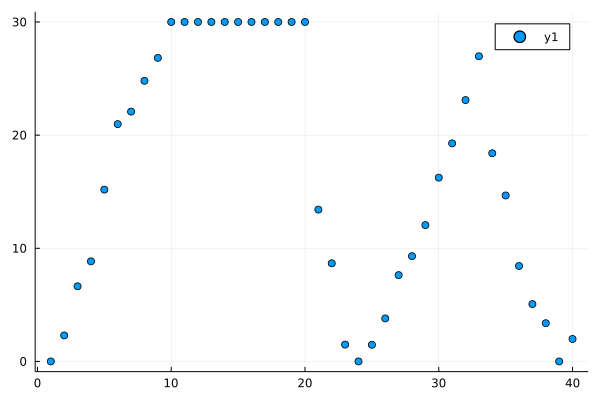

In [1299]:
sample!(xtrue)
nobs, p = 450, 1e-6
println(sum(xtrue[:,1] .< T)/N)
O = [(ti = T*rand() ; i=rand(1:N); (i,xtrue[i,1] < ti ,ti,p)) for r=1:nobs]
scatter(xtrue[:,1])

## Inference with Causality (SEIR)

In [1300]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = 1/N
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min, rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max, rate_max, rate_max);


rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max, rate_max, rate_max);


#Softened model
T = Float64(T)
ε = 1e-3
autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

θp2 = getpar(pseed, autoinf, inf_in, latency, recov);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);

In [1301]:
#Initialize the parameters to learn

autoinf = GaussianRate(2e-3, T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)
latency = GaussianRate(1., T/2, 2T)
recov = GaussianRate(1., T/2, 2T)


θ = getpar(pseed, autoinf, inf_in,  latency, recov);
M = StochasticModel(Igauss, T, θ, G, θp2gen);

In [1302]:
O

450-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (23, 1, 28.235721585412534, 1.0e-6)
 (23, 1, 17.489057258051037, 1.0e-6)
 (40, 1, 14.926327025402209, 1.0e-6)
 (8, 0, 6.9305016141302485, 1.0e-6)
 (19, 0, 16.882535068625444, 1.0e-6)
 (19, 0, 18.157810184345788, 1.0e-6)
 (39, 1, 11.689805060888755, 1.0e-6)
 (31, 1, 29.722462544510176, 1.0e-6)
 (28, 1, 27.396781589929304, 1.0e-6)
 (39, 1, 22.51672408697735, 1.0e-6)
 (24, 1, 29.78145868610348, 1.0e-6)
 (33, 0, 17.086464667584544, 1.0e-6)
 (2, 1, 15.328879268003234, 1.0e-6)
 ⋮
 (6, 0, 12.806996555676056, 1.0e-6)
 (8, 1, 27.408771599786363, 1.0e-6)
 (32, 0, 4.21839097673029, 1.0e-6)
 (32, 0, 21.428362147568077, 1.0e-6)
 (11, 0, 7.346500884543438, 1.0e-6)
 (7, 0, 19.671773245285266, 1.0e-6)
 (12, 0, 18.47389920488973, 1.0e-6)
 (33, 1, 29.117611019143315, 1.0e-6)
 (37, 1, 17.38922382478496, 1.0e-6)
 (14, 0, 8.562161766402612, 1.0e-6)
 (29, 1, 24.242038159249606, 1.0e-6)
 (16, 0, 15.691954689911402, 1.0e-6)

In [1303]:
rate_inf = M.θgen[5]
rate_lat = M.θgen[8]
rate_rec = M.θgen[11]

0.1

In [1304]:
statscauSEIR = prior(M);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Inference with Causality (SI)

In [1305]:
const IgenSI = GenerativeSI{GaussianRate,GaussianRate} 
const IgaussSI = GaussianInferentialSI
pseed_min=1/N

#inf_max = GaussianRate(1., 2T, 1/ε) 
θmin = getparSI(pseed_min , rate_min, rate_min);
θmax = getparSI(pseed_max , rate_max, rate_max);

ε = 1e-10
rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargenSI(pseed_min, rate_min, rate_min);
θgenmax = getpargenSI(pseed_max, rate_max, rate_max);


#Softened model
T = Float64(T)
ε = 2e-5
autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargenSI(pseed, autoinf, inf_out);

θp2 = getparSI(pseed, autoinf, inf_in);
Mp2SI = StochasticModel(IgenSI, T, θp2, G, θp2gen);

In [1306]:
#Initialize the parameters to learn

#autoinf = GaussianRate(1/(N*T), T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)


θ = getparSI(pseed, autoinf, inf_in);
MSI = StochasticModel(IgaussSI, T, θ, G, θp2gen);

In [1307]:
MSI.θgen

1×7 Matrix{Float64}:
 0.05  2.0e-5  15.0  15.0  0.7  15.0  1.0e10

In [1308]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2SI, O; M=MSI, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.1),hyper_mask=[1,2,3,4]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
  F:  500.4635079086576


In [1309]:
descend!(Mp2SI, O; M=MSI, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.02),hyper_mask=[1,3,4]);
MSI.θgen

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
  F:  405.7326671157605


1×7 Matrix{Float64}:
 0.05  0.000109504  15.0  15.0  1.17765  12.2743  8.99663

In [1310]:
statscauSI = prior(MSI);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Check of Hyperparameters
we now see if the hyperparameters found are consistent with the prior distribution

In [1318]:
using Plots
inferred_inf = GaussianRate(MSI.θgen[5], MSI.θgen[6] , MSI.θgen[7])


rate_inf = inf_out.a
rate_lat = l_delay.a 
rate_rec = r_delay.a 

real_trans = [rate_inf * rate_lat * exp(-(rate_inf+rate_rec)*t) *(exp((rate_inf-rate_lat+rate_rec)*t) - 1)/(rate_inf-rate_lat+rate_rec) for t=1:T]
inferred_trans=[Causality.density(inferred_inf,t) * exp(-Causality.cumulated(inferred_inf,t)) for t=1:T];

plot(real_trans, label = "SEIR_effective")
plot!(inferred_trans,label="SI_Inferred")
savefig("comparisonHyperparams.pdf")

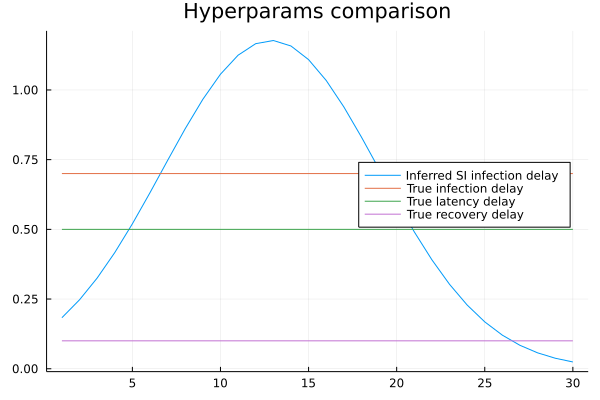

In [1312]:
using Plots
x = LinRange(0,T,Int(T))
gauss(a,b,c,x) = a .* exp.(-((x .- b)/c) .^ 2)
plot(gauss(MSI.θgen[5], MSI.θgen[6] , MSI.θgen[7], x),label="Inferred SI infection delay",legend=:right,title="Hyperparams comparison")
plot!(gauss(inf_out.a,inf_out.b,inf_out.c,x),label="True infection delay")
plot!(gauss(l_delay.a, l_delay.b, l_delay.c,x),label="True latency delay ")
plot!(gauss(r_delay.a, r_delay.b, r_delay.c,x),label="True recovery delay ")
#plot!(gauss(0.47, 8., sqrt(3.56),x),label="True latency delay ")
#plot!(gauss(0.23, 16., sqrt(6.),x),label="True recovery delay ")
#savefig("Hyperparams_SEIRvsSI")

## Marginals and ROC curve

In [1313]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i,1] .< t ) / numsamp
end

function marginalSI(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i] .< t ) / numsamp
end


function tpr(xtrue, rank) 
    den = sum(xtrue[rank])
    if den != 0
        return cumsum(xtrue[rank]) ./ den
    else
        return ones(size(rank))
    end
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

In [1314]:
O

450-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (23, 1, 28.235721585412534, 1.0e-6)
 (23, 1, 17.489057258051037, 1.0e-6)
 (40, 1, 14.926327025402209, 1.0e-6)
 (8, 0, 6.9305016141302485, 1.0e-6)
 (19, 0, 16.882535068625444, 1.0e-6)
 (19, 0, 18.157810184345788, 1.0e-6)
 (39, 1, 11.689805060888755, 1.0e-6)
 (31, 1, 29.722462544510176, 1.0e-6)
 (28, 1, 27.396781589929304, 1.0e-6)
 (39, 1, 22.51672408697735, 1.0e-6)
 (24, 1, 29.78145868610348, 1.0e-6)
 (33, 0, 17.086464667584544, 1.0e-6)
 (2, 1, 15.328879268003234, 1.0e-6)
 ⋮
 (6, 0, 12.806996555676056, 1.0e-6)
 (8, 1, 27.408771599786363, 1.0e-6)
 (32, 0, 4.21839097673029, 1.0e-6)
 (32, 0, 21.428362147568077, 1.0e-6)
 (11, 0, 7.346500884543438, 1.0e-6)
 (7, 0, 19.671773245285266, 1.0e-6)
 (12, 0, 18.47389920488973, 1.0e-6)
 (33, 1, 29.117611019143315, 1.0e-6)
 (37, 1, 17.38922382478496, 1.0e-6)
 (14, 0, 8.562161766402612, 1.0e-6)
 (29, 1, 24.242038159249606, 1.0e-6)
 (16, 0, 15.691954689911402, 1.0e-6)

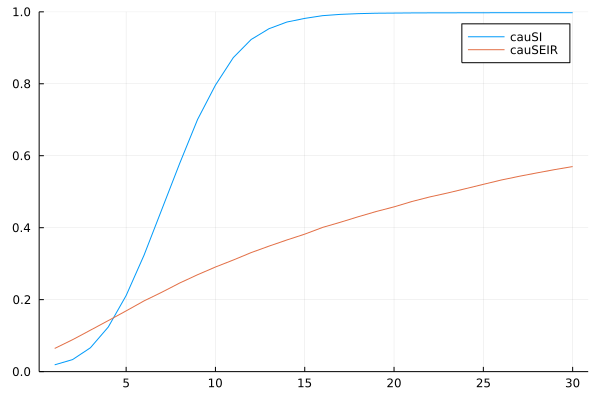

In [1232]:
using Plots
p_cauSEIR = zeros(N,Int(T))
p_cauSI = zeros(N,Int(T))
for i = 1:N
    for t = 1:Int(T)
       p_cauSEIR[i,t] = marginal(i, t, statscauSEIR)
       p_cauSI[i,t] = marginalSI(i, t, statscauSI)
    end
end
i = 48
plot(p_cauSI[i,1:end], label = "cauSI")
plot!(p_cauSEIR[i,1:end], label = "cauSEIR")
#savefig("SEIRmarkov.pdf")
ylims!(0,1)

In [1233]:
sortperm(p_cauSI[:,end],rev=true)

60-element Vector{Int64}:
  9
 10
 47
 11
 46
  7
  8
  6
  5
  4
 45
 12
 13
  ⋮
 28
 29
 38
 30
 17
 20
 24
 35
 33
 25
 43
 39

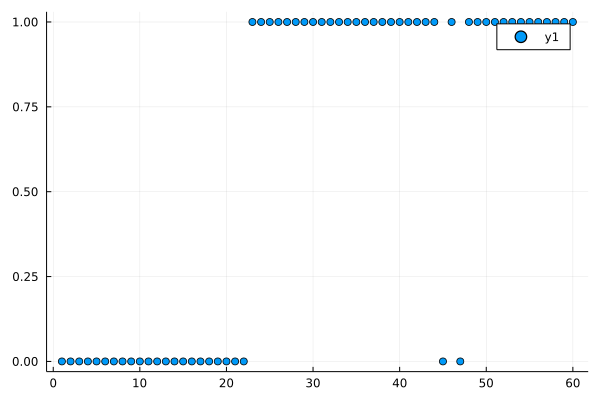

In [1234]:
scatter(xtrue[sortperm(p_cauSI[:,end],rev=true),1] .== T)

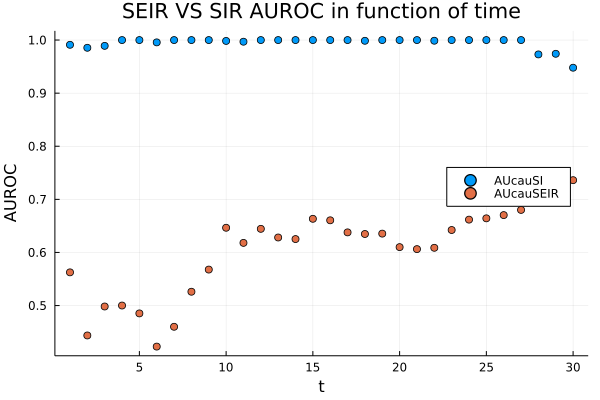

In [1235]:
T = Int(T)
AU_cauSEIR=zeros(T)
AU_cauSI=zeros(T)
for t = 1:T
    cauSEIR_risk=zeros(N)
    cauSI_risk=zeros(N)
    for i=1:N
       cauSEIR_risk[i] = marginal(i,t,statscauSEIR)
       cauSI_risk[i] = marginalSI(i,t,statscauSI)
    end
    xt = xtrue[:,1] .< t-1e-3 
    AU_cauSEIR[t] = AUROC(ROC(xt, cauSEIR_risk))
    AU_cauSI[t] = AUROC(ROC(xt, cauSI_risk))
end

scatter(LinRange(1,T,T),AU_cauSI, label="AUcauSI",legend=:right)
scatter!(LinRange(1,T,T),AU_cauSEIR, label="AUcauSEIR", title="SEIR VS SIR AUROC in function of time")

T = Float64(T)
#ylims!(0.5,1.05)
savefig("SierologicalAUROC")
xlabel!("t")
ylabel!("AUROC")

## The number of infected

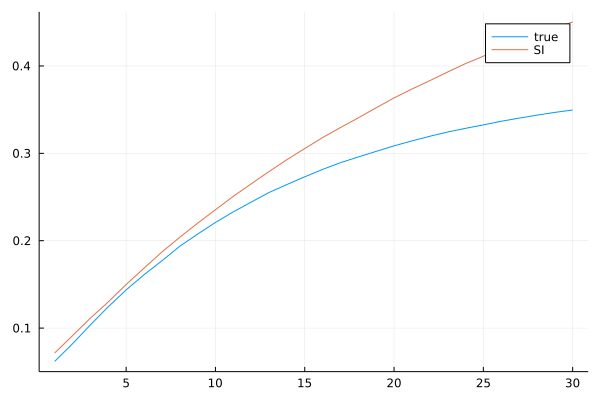

In [1236]:
trials = 1000
xSI = zeros(N)
xSEIR = zeros(N, Int(T))
xorig = zeros(N,Int(T))
sampleSI! = Sampler(Mp2SI)
sampleSEIR! = Sampler(Mp2)
ni_orig = zeros(Int(T))
ni_SEIR = zeros(Int(T))
ni_SI = zeros(Int(T))
ni_planted = zeros(Int(T))
for st = 1:trials
    sampleSI!(xSI)
    sample!(xorig)
    sampleSEIR!(xSEIR)
    for t = 1:Int(T)
        ni_orig[t] += sum(xorig[:,1] .< t)
        ni_SEIR[t] += sum(xSEIR[:,1] .< t)
        ni_SI[t] += sum(xSI .< t)
        ni_planted[t] = sum(xtrue[:,1] .< t)
    end
end
plot(ni_orig./trials/N,label="true")
plot!(ni_SI./trials/N,label="SI")
#plot!(ni_SEIR./trials/N,label="SEIR")
#plot!(ni_planted/N,label="planted")